In [1]:
# I will use `sys` for ensure that if you run the code from this notebook
# it will automatically download all the required libraries with pip
# N.B.: better to run this code in a virtual environment
import sys

# I will use os for accessing files
import os

# I will use time to calculate the response time of the various algorithms
# and to do some other things like don't welcome twice the same person if it is
# detected in consecutive 
import time

In [2]:
!{sys.executable} --version  

Python 3.9.16


In [3]:
# This will install numpy library
#!{sys.executable} -m pip -q install numpy
import numpy as np

In [4]:
# This will install face_recognition library
!{sys.executable} -m pip -q install face_recognition
import face_recognition

# importing pickle, used to save and load face embeddings
import pickle

In [5]:
# importing openCV
!{sys.executable} -m pip -q install opencv-python
!{sys.executable} -m pip install opencv-contrib-python
import cv2

In [6]:
#importing mediapipe
!{sys.executable} -m pip -q install mediapipe
import mediapipe as mp
import math

In [7]:
# N.B: Run the code below only if you are running it on a raspberry pi with an installde pi camera modulo

import picamera

with picamera.PiCamera() as camera:
    time.sleep(2)
    camera.exposure_mode = 'sports'
    camera.resolution = (640, 480)

ModuleNotFoundError: No module named 'picamera'

### DetectionDemo

This will be my testing class for face detection and face recognition algorithms.
I will use the `VideoCapture` from openCV to capture the image from the camera. There should be another method that is `PiCamera.capture` but I've seen that this method was taking too much time andit was a bottleneck for my system, maybe because the way that methos saves the image on the disk and then back to my code.
And secondly with `VideoCapture` i can generalize better and use the code below even on other systems.

`IPhyton.display` is a library that allows me to show images with jupiter notebook and so debug my system while running

In [143]:
class Box:
    def __init__(self, bbox, timestamp, name=None):
        self.update(bbox, timestamp)
        self.name = name
        self.recognized = []
        
    def update(self, bbox, timestamp):
        (top,right,bottom,left) = bbox
        self.top = top
        self.right = right
        self.bottom = bottom
        self.left = left        
        self.timestamp = timestamp
        
    def setRecognition(self, name):
        if name != "unknown" and name in self.recognized:
            self.name = name
            return
        
        self.recognized.append(name)
        if len(self.recognized) > 10:
            # if after 10 attempt cant recognize twice set person as unknown
            self.name = "unknown"
        self.timestamp = time.time()
            
    def isExpired(self):
        return (time.time() - self.timestamp) >= 1
    
    def isCentered(self, bbox):
        (top,right,bottom,left) = bbox
        center = (
            int(left + ((right - left) / 2)), 
            int(top + ((bottom - top) / 2))
        )
                
        return center[0] > self.left and center[0] < self.right and center[1] > self.top and center[1] < self.bottom
    
    def shouldRecognize(self, bbox):
        # update values
        self.update(bbox, time.time())
        
        return self.name == None

In [144]:
from cv2 import VideoCapture
from IPython.display import display, Image
import traceback
        

class DetectionDemo: 
    
    def __init__(self, detector, recognizer, motion=None):
        """
        the detector will return the corners in css format of the detected faces
        the recognizer will do the face recognition task given the face locations
        """
        self.detector = detector
        self.recognizer = recognizer
        self.motion = motion
        self.cap = VideoCapture(0)
        
    def run(self):
        # used to display image on the notebook
        display_handle=display(None, display_id=True)
        
        detection_duration_list = list()
        recognition_duration_list = list() 
        tmp_boxes = list()
        try:
            while True:        
                # read the image from the opencv video stream
                _, img = self.cap.read()
                                
                # mac camera has resolution of 1280*720 -> i have to cut to have a multiple of 640*480
                # doing that i am using the mac camera with the same resolution i will use on the raspbery
                # so i can test it before with my mac and then with the raspberry
                if np.shape(img)[0] == 720 and np.shape(img)[1] == 1280:
                    img = img[ :, 160:-160, :] # now i have the same resolution of the pi camera
                    img = cv2.flip(img, 1) # flip the image if using frontal camera

                # reshape the image to 640*480 (if we are in a not raspberry environment)
                #img = cv2.resize(img, (640, 480))
                
                # given the image from the raspberry camera i can see that i can restrict the area where to apply
                # face detection making it a little bit bigger than the door where people can come inside
                #img = img[100:-140, 160:-160, :]

                # convert to rgb for face detection tasks
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                
                # DETECT FACES
                if self.detector:
                    detector_start = time.time()
                    faces = self.detector(img)
                    detection_duration_list.append(time.time() - detector_start)
                    
                    
                    # print bounding box
                    for face in faces:
                        (top,right,bottom,left) = face
                        img = cv2.rectangle(img,(right,top),(left, bottom),(0,0,255),2)
                    
                    face_to_compute = list()

                    if len(tmp_boxes) == 0:
                        tmp_boxes = [Box(face, time.time()) for face in faces]
                        face_to_compute = [Box(face, time.time()) for face in faces]
                    else:
                        to_add = []
                        for face in faces:
                            (top,right,bottom,left) = face
                            found = False
                            for tmp_box in tmp_boxes:
                                if tmp_box.isCentered(face): 
                                    # if a face is on a box check if i have to recognize
                                    found = True
                                    if tmp_box.shouldRecognize(face):
                                        face_to_compute.append(tmp_box)
                                    else:
                                        img = cv2.putText(img, tmp_box.name, (left, top), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)
                            
                            # if a face is not on any box add it
                            if not found:
                                box = Box(face, time.time())
                                face_to_compute.append(box)
                                to_add.append(box)
                                    
                        tmp_boxes.extend(to_add)
                    
                    if self.recognizer:
                        recognizer_start = time.time()
                        self.recognizer(img, face_to_compute)
                        recognition_duration_list.append(time.time() - recognizer_start)
                        
                    # removing expired boxes
                    to_rm = [b for b in tmp_boxes if b.isExpired()]
                    if len(to_rm) > 0:
                        print("removed box")
                    tmp_boxes = [b for b in tmp_boxes if not b.isExpired()]
                        

                # convert back to bgr
                img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
                
                # convert image to jpe (this is the fastest type of conversion i have found for the raspberry)
                cv2.imencode('.jpe', img)

                # showing image on the notebook output
                display_handle.update(Image(data=cv2.imencode('.jpe', img)[1].tobytes()))
                
        except KeyboardInterrupt:
            # here i intercept the stop command of the notebook so i can print the results
            pass
        except Exception as e: 
            # intercept other kind of expressions
            print(e)
            print(traceback.format_exc())
            pass
        finally:
            # print average duration of face detection
            if len(detection_duration_list) != 0:
                det = sum(detection_duration_list)/len(detection_duration_list)
                print("Mean time detection: {}".format(det))
            
            # average duration of face recognition
            if len(recognition_duration_list) != 0:
                rec = sum(recognition_duration_list)/len(recognition_duration_list)
                print("Mean time recognition: {}".format(rec))
           
            # release the video camera
            self.cap.release() 

### MediaPipe Detector

In [61]:
# creating the model for BlazeFace with mediapipe
mp_face_detection = mp.solutions.face_detection
face_detection = mp_face_detection.FaceDetection(model_selection=0, min_detection_confidence=0.65)

def normalize_pixel_coord(
    normalized_x: float,
    normalized_y: float, 
    image_width: int,
    image_height: int
):
    """
    mediapipe return a normalized bounding box with relative distances
    with this method i come back to the true position of the points
    """
    x_px = min(math.floor(normalized_x * image_width), image_width - 1)
    y_px = min(math.floor(normalized_y * image_height), image_height - 1)
    return x_px, y_px

def detectMediapipe(img):
    # detect face
    faces = face_detection.process(img)
    norm_detections = []
    if faces.detections:
        for detection in faces.detections:
            # i have to convert the relative bounding box to 
            # css format bounding box
            points = detection.location_data.relative_bounding_box
            img_height, img_width, _ = np.shape(img)
            top = int(points.ymin * img_height)
            bottom = int((points.ymin + points.height) * img_height)
            left = int(points.xmin * img_width)
            right = int((points.xmin + points.width) * img_width)
            norm_detections.append((top, right, bottom, left))
    return norm_detections

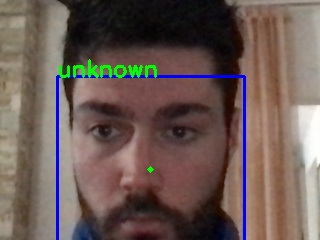

Mean time detection: 0.0030907897316679663


In [62]:
# run detection demo with mediapipe
detector = DetectionDemo(detector = detectMediapipe, recognizer = None)
detector.run()

## Haar cascade detector

In [97]:
# load model
face_detector = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

def detectHaar(img):
    # transform the image in gray scale
    gray_img = cv2.cvtColor(img, cv2.COLOR_RGBA2GRAY)
        
    # DETECT FACES
    faces = face_detector.detectMultiScale(gray_img, scaleFactor=1.3, minNeighbors=6)
    norm_detections = []
    
    for (x,y,w,h) in faces:
        # calculate css bounding box
        norm_detections.append((y, x+w, y+h, x))
    return norm_detections 

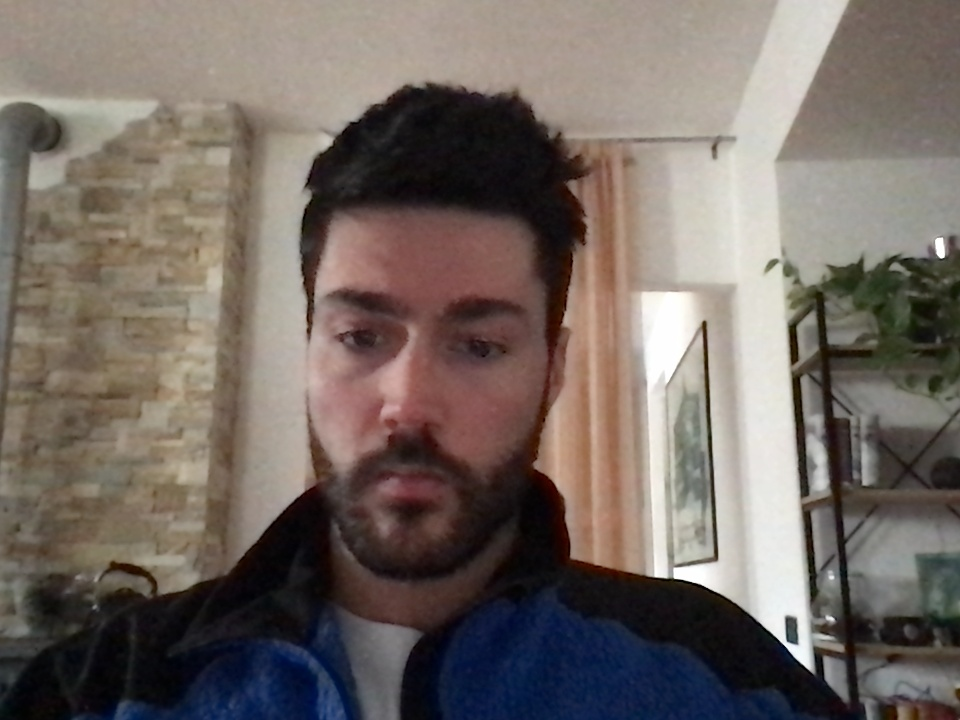

Mean time detection: 0.01921409147757071


In [139]:
# run haar cascade demo
detector = DetectionDemo(detector = detectHaar, recognizer = None)
detector.run()

## HOG detector

In [19]:
def detectHog(img):
    # detect faces with hog detector
    faces = face_recognition.face_locations(img, number_of_times_to_upsample=1, model='hog')
    return faces 

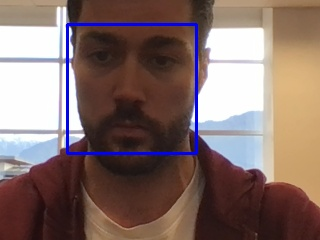

Mean time detection: 0.04769747881662278


In [20]:
# run hog detector demo
detector = DetectionDemo(detector = detectHog, recognizer = None)
detector.run()

# Face recognition

In [145]:
# load already calculated encodings
encodings = dict()
print("loading features")
for f in os.listdir('features'):
    # added that condition because system can create tmp files like .DS_Store
    if f.endswith("dat"):
        name = f[:-4]
        if name in encodings:
            continue
        with open('features/' + f, 'rb') as n:
            print('Adding features for ' + name)
            encodings[name] = pickle.load(n)
        
def getClosestName(names, distances):
    """
    get the name of the person that has the lower
    distance from the detected face or if the distance
    is too high return "unknown"
    """
    min_val = 1.0
    name = "unknown"
    for index, n in names:
        dist = distances[index]
        if dist <= min_val and dist < 0.6:
            name = n
            min_val = distances[index]
    return name
        
        
def recognize(img, boxes):
    # get face encodings
    faces = [(b.top, b.right, b.bottom, b.left) for b in boxes]
    
    face_encodings = face_recognition.face_encodings(img, faces, model="large")

    # Loop over each face found in the frame to see if it's someone we know.
    for i, face_encoding in enumerate(face_encodings):
        # calculate face distances
        matches = face_recognition.face_distance(list(encodings.values()), face_encoding)
        # get best fitting name
        name = getClosestName(enumerate(encodings.keys()), matches)
        boxes[i].setRecognition(name)
        # label bounding box with name
        img = cv2.putText(img, name, (faces[i][3], faces[i][0]), cv2.FONT_HERSHEY_SIMPLEX, 0.75, (0, 255, 0), 2)

loading features
Adding features for riccardo


## Mediapipe + recognition

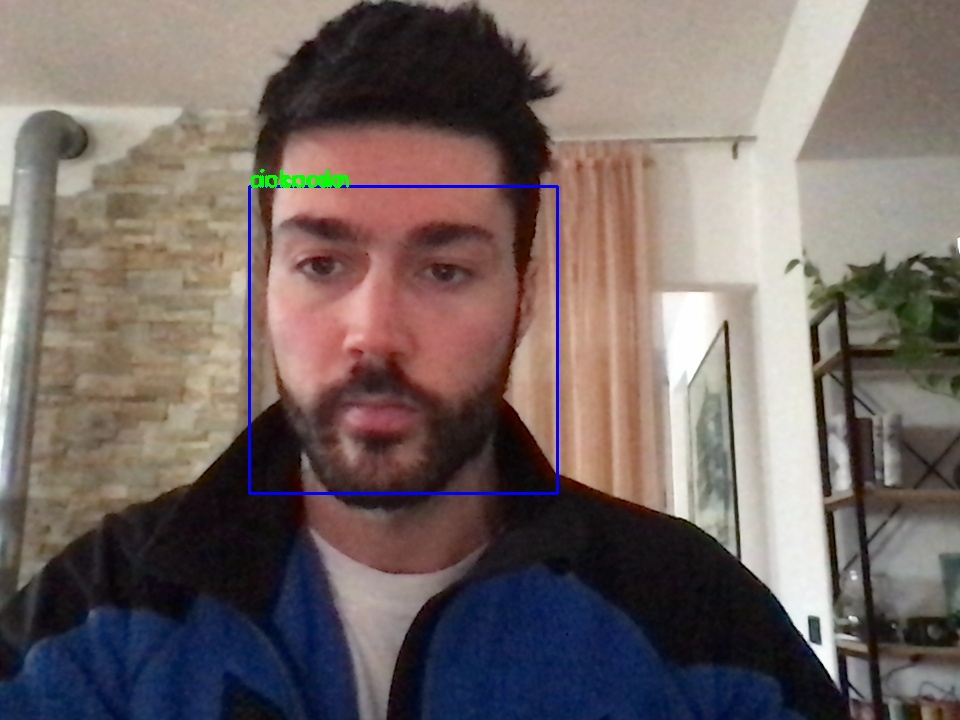

removed box
removed box
removed box
removed box
removed box
removed box
Mean time detection: 0.0028826086363970427
Mean time recognition: 0.0015955800760161603


In [146]:
# run recognition with mediapipe
detector = DetectionDemo(detector = detectMediapipe, recognizer = recognize)
detector.run()

## Haar + recognition

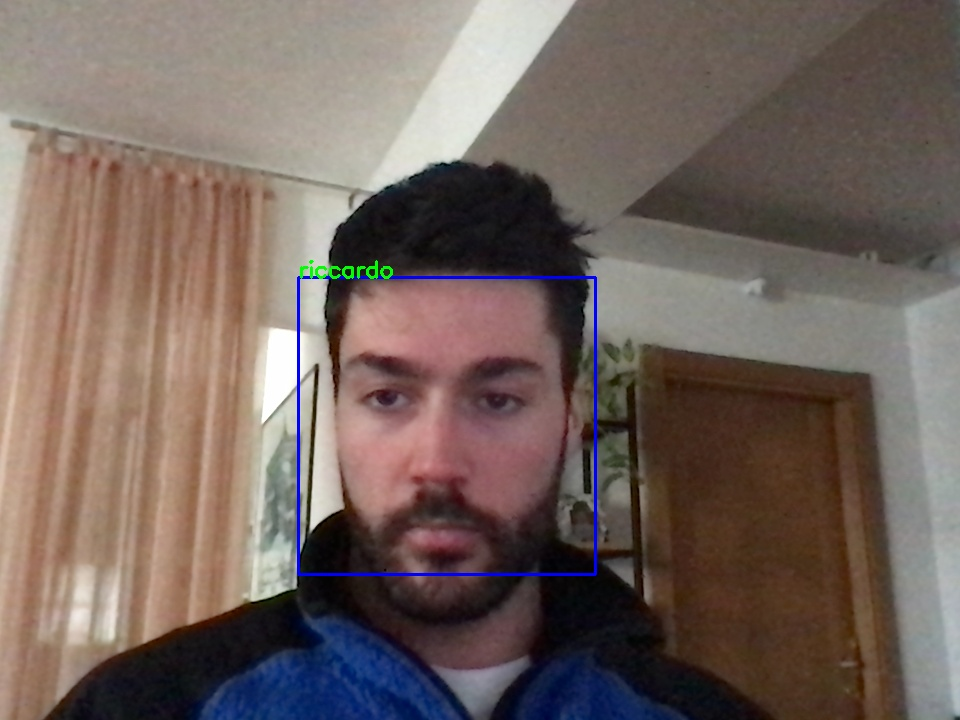

removed box
removed box
removed box
removed box
removed box
Mean time detection: 0.019221044819930505
Mean time recognition: 0.0003716399516965368


In [147]:
# run recognition with haar
detector = DetectionDemo(detector = detectHaar, recognizer = recognize)
detector.run()